In [1179]:
from dataclasses import asdict, dataclass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Generator, Optional
from scipy.signal import find_peaks
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from itertools import product

# constants
INPUT_FILE = "data/full_cycle_with_idle.txt"
ACCELEROMETER_SAMPLE_RATE_HZ = 104
Z_SCORE_THRESHOLD = 3
MILLIS_OFFSET = 3702

# function to read text files, parse into dataclass
@dataclass
class AccelerometerReading:
  timeStampMs: int
  x: float
  y: float
  z: float

# sample reading: 19:09:28:874 -> 3702 -> (0.004, 0.460, 0.003)
def parseReading(reading: str) -> Optional[AccelerometerReading]:
  dataParts = reading.split(" -> ")
  if len(dataParts) != 2:
    print(f'Expected 2 parts of data, received {len(dataParts)}')
    return None

  timeStr = dataParts[0]
  readingStr = dataParts[1]

  # parse time value
  timeValue = None
  try:
    timeValue = int(timeStr) - MILLIS_OFFSET # offset first reading to be at t=0
  except:
    print(f'failed to parse time component of {reading}: {timeStr}')
    return None

  # remove parenthesis from readingStr
  readingStr = readingStr.removeprefix("(")
  readingStr = readingStr.removesuffix(")")
  readingVals = readingStr.strip().split(", ")
  if len(readingVals) != 3:
    print(f'failed to read string: {reading}')
    return None
  
  x, y, z = 0.0, 0.0, 0.0

  try:
    x = float(readingVals[0].strip())
    y = float(readingVals[1].strip())
    z = float(readingVals[2].strip())
  except:
    print(f'failed to read string: {reading}')
    return None

  return AccelerometerReading(timeValue, x, y, z)

def readFileLineGenerator(path: Path) -> Generator[str, None, None]:
  with open(path, "r") as file:
    for line in file:
      yield line.strip()

In [1148]:
# read input files into generator objects, parse them
rawReadings = readFileLineGenerator(INPUT_FILE)
parsedReadings = (parseReading(readingString) for readingString in rawReadings)

In [1149]:
# convert to dictionary for transformation into pandas dataframe, excluding parsing failures
readingsDict = (asdict(reading) for reading in parsedReadings if reading is not None)

readingsDf = pd.DataFrame(readingsDict)
readingsDf.describe()

,timeStampMs,x,y,z
count,8.725480e+05,872548.000000,872548.000000,872548.000000
mean,4.183147e+06,0.013524,-0.973123,0.019159
std,2.415225e+06,0.011087,0.303917,0.017070
min,0.000000e+00,0.000000,-1.161000,0.000000
25%,2.091518e+06,0.009000,-1.022000,0.011000
50%,4.183038e+06,0.012000,-1.019000,0.015000
75%,6.274750e+06,0.016000,-1.017000,0.023000
max,8.366646e+06,0.285000,0.999000,0.443000


In [1150]:
# preprocess for preliminary plotting
readingsDf = readingsDf.sort_values('timeStampMs') # keep time-series sorted

# throw out the first 2 readings, sensor is not yet normalized
readingsDf = readingsDf[readingsDf.index > 1]

# label data regions
idle_region_timestamps = [[0, 163200], [3993208, 4284609], [7644302, 8366646]]
washing_machine_final_timestamp = 3900108
dryer_final_timestamp = 7600227

readingsDf['state'] = "IDLE"
readingsDf.loc[(readingsDf['timeStampMs'] > idle_region_timestamps[0][1]) & (readingsDf['timeStampMs'] < idle_region_timestamps[1][0]), 'state'] = "WASHING"
readingsDf.loc[(readingsDf['timeStampMs'] > idle_region_timestamps[1][1]) & (readingsDf['timeStampMs'] < idle_region_timestamps[2][0]), 'state'] = "DRYING"

# calculate magnitude
readingsDf['magnitude'] = np.round(np.sqrt(readingsDf['x']**2 + readingsDf['y']**2 + readingsDf['z'] ** 2), 3) # calculate magnitude of acceleration vector

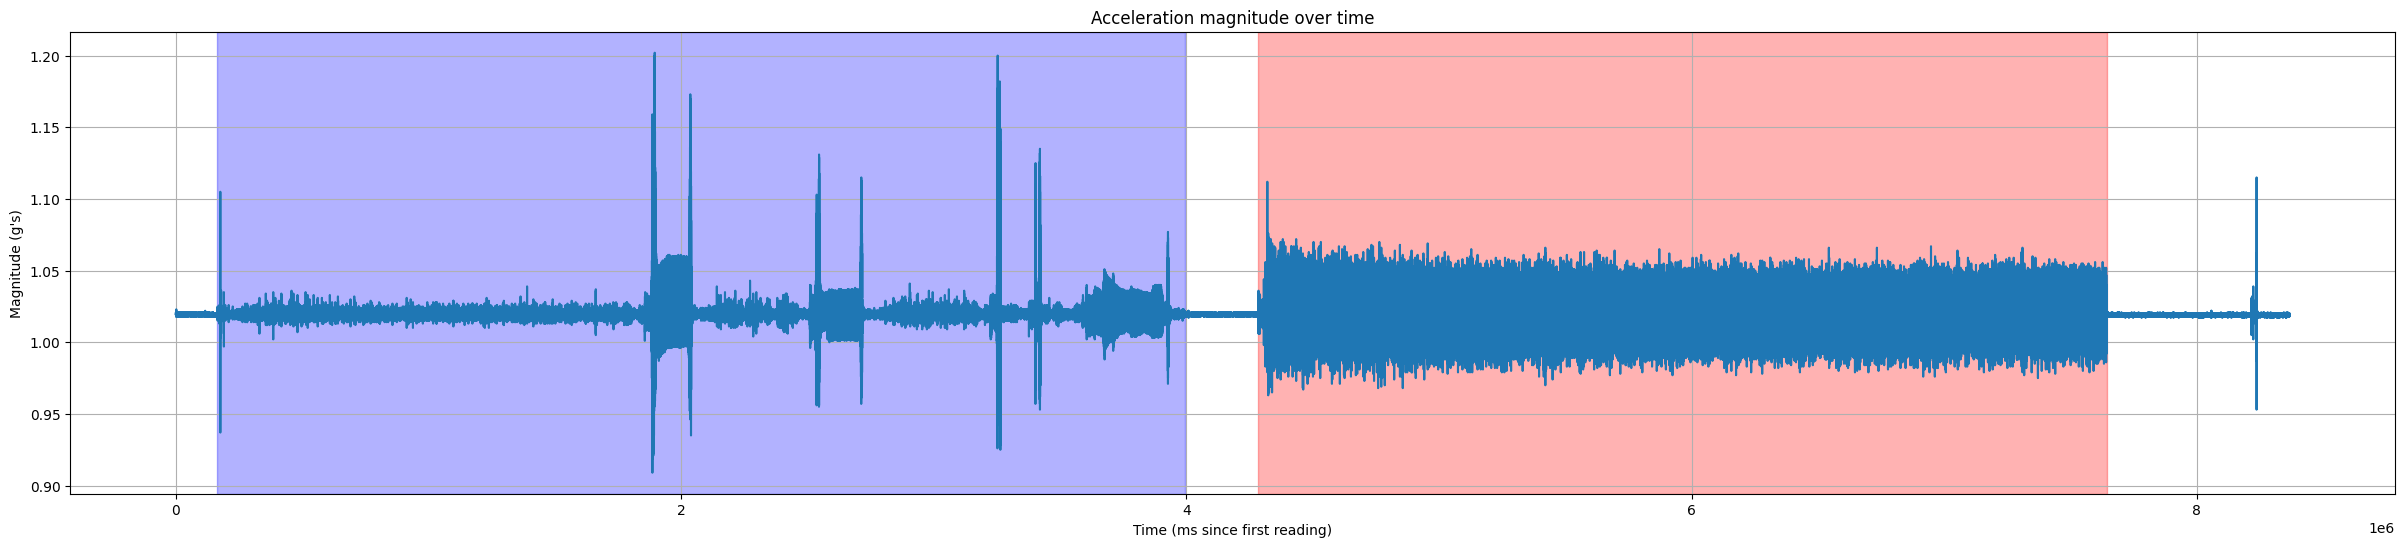

In [1151]:
plt.figure(figsize=(30, 6))
plt.plot(readingsDf['timeStampMs'], readingsDf['magnitude'])

# Highlight regions based on the state
plt.axvspan(idle_region_timestamps[0][1], idle_region_timestamps[1][0], color='blue', alpha=0.3, label="Washing")
plt.axvspan(idle_region_timestamps[1][1], idle_region_timestamps[2][0], color='red', alpha=0.3, label="Washing")

plt.title('Acceleration magnitude over time')
plt.xlabel('Time (ms since first reading)')
plt.ylabel('Magnitude (g\'s)')
plt.grid(True)
plt.show()

In [1154]:
# break out each individual state for analysis (idle is not contiguous, so it's in 3 tranches)
idle_period_1 = readingsDf[(readingsDf['state'] == "IDLE") & (readingsDf['timeStampMs'] <= idle_region_timestamps[0][1])]
idle_period_2 = readingsDf[(readingsDf['state'] == "IDLE") & (readingsDf['timeStampMs'] >= idle_region_timestamps[1][0]) & (readingsDf['timeStampMs'] <= idle_region_timestamps[1][1])]
idle_period_3 = readingsDf[(readingsDf['state'] == "IDLE") & (readingsDf['timeStampMs'] >= idle_region_timestamps[2][0])]
washing = readingsDf[readingsDf['state'] == "WASHING"]
drying = readingsDf[readingsDf['state'] == "DRYING"]

In [1159]:
all_idle_df = readingsDf[readingsDf['state'] == "IDLE"]
all_idle_df.describe()

,timeStampMs,x,y,z,magnitude
count,1.227380e+05,122738.000000,122738.000000,122738.000000,122738.000000
mean,5.949217e+06,0.011974,-1.019010,0.015165,1.019243
std,2.865209e+06,0.003010,0.021417,0.001832,0.000965
min,1.900000e+01,0.000000,-1.093000,0.000000,0.953000
25%,4.124222e+06,0.011000,-1.020000,0.015000,1.019000
50%,7.778132e+06,0.012000,-1.019000,0.015000,1.019000
75%,8.072388e+06,0.012000,-1.019000,0.015000,1.020000
max,8.366646e+06,0.273000,0.999000,0.271000,1.115000


In [1160]:
idle_spread = all_idle_df['magnitude'].max() - all_idle_df['magnitude'].min()
idle_spread

np.float64(0.16200000000000003)

Among the idle readings, there is very little variability. 

The spread of the magnitude (max less min) is 0.162G.
The standard deviation on the magnitude is 0.000965G.

It stands to reason, anything over 1.019 + 0.16 -> 1.179 can be classified as active.

The only question is the period of that activity. Over how long a time period should activity be polled?

In [1161]:
washing.describe()

,timeStampMs,x,y,z,magnitude
count,3.994530e+05,399453.000000,399453.000000,399453.000000,399453.000000
mean,2.078202e+06,0.013955,-0.992112,0.019154,1.019949
std,1.105630e+06,0.013713,0.234926,0.020635,0.008144
min,1.632040e+05,0.000000,-1.161000,0.000000,0.909000
25%,1.120701e+06,0.010000,-1.021000,0.011000,1.018000
50%,2.078202e+06,0.012000,-1.020000,0.015000,1.020000
75%,3.035702e+06,0.015000,-1.018000,0.021000,1.021000
max,3.993199e+06,0.285000,0.999000,0.443000,1.202000


In [1162]:
drying.describe()

,timeStampMs,x,y,z,magnitude
count,3.503550e+05,350355.000000,350355.000000,350355.000000,350355.000000
mean,5.964401e+06,0.013575,-0.935406,0.020565,1.019789
std,9.698718e+05,0.009355,0.405413,0.015214,0.011557
min,4.284618e+06,0.000000,-1.081000,0.000000,0.963000
25%,5.124450e+06,0.006000,-1.027000,0.008000,1.012000
50%,5.964377e+06,0.012000,-1.019000,0.018000,1.020000
75%,6.804334e+06,0.020000,-1.012000,0.030000,1.027000
max,7.644292e+06,0.223000,0.999000,0.209000,1.112000


# Binary Classification
The below code was arrived at after much trial and error, including the use of frequency analysis.

Keeping in mind that the classifier will be running on embedded hardware, this seemed the most practical and effective solution.

The below code is a grid search for a local optimal solution between the size of the rolling window of observations and the proportion of those observations which are "active" for the overall window to be considered a period of activity.

The thresholds for an individual observation's magnitude to be considered "active" are defined based on hand-labeled "idle" data; observations in excess of the 99th percentile of idle observations are considered active. Observations less than the first percentile are also considered active, since the nature of the accelerometer data includes a reaction of roughly equal magnitude to the initial impulse - the machine accelerates, decelerates, and then accelerates back to its original position, like a pendulum.

In [1182]:
data = readingsDf

data['actual_state'] = np.where(data['state'] != "IDLE", "ACTIVE", "IDLE")

lookback_periods = np.arange(1, 1024, 100)
proportions = np.arange(0.01, .99, .05)

upper_threshold = data[data["actual_state"] == "IDLE"]['magnitude'].quantile(.99)
lower_threshold = data[data['actual_state'] == "IDLE"]['magnitude'].quantile(0.01)

data['above_upper'] = data['magnitude'] > upper_threshold
data['below_lower'] = data['magnitude'] < lower_threshold

best_f1 = 0
best_conf_matrix = None
best_report = None
best_lookback = None
best_proportion = None

prod = list(product(lookback_periods, proportions))

iteration = 1
num_iterations = len(prod)
for lookback_period, proportion_active in prod:
  print(f"Iteration: {iteration} of {num_iterations}, {iteration / num_iterations * 100:.2f}%")
  iteration += 1
  rolling_above_upper = data['above_upper'].rolling(window=lookback_period).mean() >= proportion_active
  rolling_below_lower = data['below_lower'].rolling(window=lookback_period).mean() >= proportion_active

  data['predicted_state'] = np.where(rolling_above_upper | rolling_below_lower, "ACTIVE", "IDLE")
  data.fillna({'predicted_state': "IDLE"}, inplace=True)

  labels = ['IDLE', 'ACTIVE']

  conf_matrix = confusion_matrix(data['actual_state'], data['predicted_state'], labels=labels)
  report = classification_report(data['actual_state'], data['predicted_state'], labels=labels)
  f1 = f1_score(data['actual_state'], data['predicted_state'], labels=labels, pos_label="ACTIVE")

  if f1 > best_f1:
    best_f1 = f1
    best_conf_matrix = conf_matrix
    best_report = report
    best_lookback = lookback_period
    best_proportion = proportion_active

print("Best Confusion matrix:")
print(best_conf_matrix)

print("\n")
print("Best Classification Report:")
print(best_report)


Iteration: 1 of 220, 0.45%
Iteration: 2 of 220, 0.91%
Iteration: 3 of 220, 1.36%
Iteration: 4 of 220, 1.82%
Iteration: 5 of 220, 2.27%
Iteration: 6 of 220, 2.73%
Iteration: 7 of 220, 3.18%
Iteration: 8 of 220, 3.64%
Iteration: 9 of 220, 4.09%
Iteration: 10 of 220, 4.55%
Iteration: 11 of 220, 5.00%
Iteration: 12 of 220, 5.45%
Iteration: 13 of 220, 5.91%
Iteration: 14 of 220, 6.36%
Iteration: 15 of 220, 6.82%
Iteration: 16 of 220, 7.27%
Iteration: 17 of 220, 7.73%
Iteration: 18 of 220, 8.18%
Iteration: 19 of 220, 8.64%
Iteration: 20 of 220, 9.09%
Iteration: 21 of 220, 9.55%
Iteration: 22 of 220, 10.00%
Iteration: 23 of 220, 10.45%
Iteration: 24 of 220, 10.91%
Iteration: 25 of 220, 11.36%
Iteration: 26 of 220, 11.82%
Iteration: 27 of 220, 12.27%
Iteration: 28 of 220, 12.73%
Iteration: 29 of 220, 13.18%
Iteration: 30 of 220, 13.64%
Iteration: 31 of 220, 14.09%
Iteration: 32 of 220, 14.55%
Iteration: 33 of 220, 15.00%
Iteration: 34 of 220, 15.45%
Iteration: 35 of 220, 15.91%
Iteration: 36 o

/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 38 of 220, 17.27%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 39 of 220, 17.73%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 40 of 220, 18.18%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 41 of 220, 18.64%
Iteration: 42 of 220, 19.09%
Iteration: 43 of 220, 19.55%
Iteration: 44 of 220, 20.00%
Iteration: 45 of 220, 20.45%
Iteration: 46 of 220, 20.91%
Iteration: 47 of 220, 21.36%
Iteration: 48 of 220, 21.82%
Iteration: 49 of 220, 22.27%
Iteration: 50 of 220, 22.73%
Iteration: 51 of 220, 23.18%
Iteration: 52 of 220, 23.64%
Iteration: 53 of 220, 24.09%
Iteration: 54 of 220, 24.55%
Iteration: 55 of 220, 25.00%
Iteration: 56 of 220, 25.45%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 57 of 220, 25.91%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 58 of 220, 26.36%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 59 of 220, 26.82%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 60 of 220, 27.27%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 61 of 220, 27.73%
Iteration: 62 of 220, 28.18%
Iteration: 63 of 220, 28.64%
Iteration: 64 of 220, 29.09%
Iteration: 65 of 220, 29.55%
Iteration: 66 of 220, 30.00%
Iteration: 67 of 220, 30.45%
Iteration: 68 of 220, 30.91%
Iteration: 69 of 220, 31.36%
Iteration: 70 of 220, 31.82%
Iteration: 71 of 220, 32.27%
Iteration: 72 of 220, 32.73%
Iteration: 73 of 220, 33.18%
Iteration: 74 of 220, 33.64%
Iteration: 75 of 220, 34.09%
Iteration: 76 of 220, 34.55%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 77 of 220, 35.00%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 78 of 220, 35.45%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 79 of 220, 35.91%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 80 of 220, 36.36%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 81 of 220, 36.82%
Iteration: 82 of 220, 37.27%
Iteration: 83 of 220, 37.73%
Iteration: 84 of 220, 38.18%
Iteration: 85 of 220, 38.64%
Iteration: 86 of 220, 39.09%
Iteration: 87 of 220, 39.55%
Iteration: 88 of 220, 40.00%
Iteration: 89 of 220, 40.45%
Iteration: 90 of 220, 40.91%
Iteration: 91 of 220, 41.36%
Iteration: 92 of 220, 41.82%
Iteration: 93 of 220, 42.27%
Iteration: 94 of 220, 42.73%
Iteration: 95 of 220, 43.18%
Iteration: 96 of 220, 43.64%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 97 of 220, 44.09%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 98 of 220, 44.55%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 99 of 220, 45.00%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 100 of 220, 45.45%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 101 of 220, 45.91%
Iteration: 102 of 220, 46.36%
Iteration: 103 of 220, 46.82%
Iteration: 104 of 220, 47.27%
Iteration: 105 of 220, 47.73%
Iteration: 106 of 220, 48.18%
Iteration: 107 of 220, 48.64%
Iteration: 108 of 220, 49.09%
Iteration: 109 of 220, 49.55%
Iteration: 110 of 220, 50.00%
Iteration: 111 of 220, 50.45%
Iteration: 112 of 220, 50.91%
Iteration: 113 of 220, 51.36%
Iteration: 114 of 220, 51.82%
Iteration: 115 of 220, 52.27%
Iteration: 116 of 220, 52.73%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 117 of 220, 53.18%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 118 of 220, 53.64%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 119 of 220, 54.09%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 120 of 220, 54.55%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 121 of 220, 55.00%
Iteration: 122 of 220, 55.45%
Iteration: 123 of 220, 55.91%
Iteration: 124 of 220, 56.36%
Iteration: 125 of 220, 56.82%
Iteration: 126 of 220, 57.27%
Iteration: 127 of 220, 57.73%
Iteration: 128 of 220, 58.18%
Iteration: 129 of 220, 58.64%
Iteration: 130 of 220, 59.09%
Iteration: 131 of 220, 59.55%
Iteration: 132 of 220, 60.00%
Iteration: 133 of 220, 60.45%
Iteration: 134 of 220, 60.91%
Iteration: 135 of 220, 61.36%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 136 of 220, 61.82%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 137 of 220, 62.27%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 138 of 220, 62.73%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 139 of 220, 63.18%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 140 of 220, 63.64%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 141 of 220, 64.09%
Iteration: 142 of 220, 64.55%
Iteration: 143 of 220, 65.00%
Iteration: 144 of 220, 65.45%
Iteration: 145 of 220, 65.91%
Iteration: 146 of 220, 66.36%
Iteration: 147 of 220, 66.82%
Iteration: 148 of 220, 67.27%
Iteration: 149 of 220, 67.73%
Iteration: 150 of 220, 68.18%
Iteration: 151 of 220, 68.64%
Iteration: 152 of 220, 69.09%
Iteration: 153 of 220, 69.55%
Iteration: 154 of 220, 70.00%
Iteration: 155 of 220, 70.45%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 156 of 220, 70.91%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 157 of 220, 71.36%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 158 of 220, 71.82%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 159 of 220, 72.27%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 160 of 220, 72.73%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 161 of 220, 73.18%
Iteration: 162 of 220, 73.64%
Iteration: 163 of 220, 74.09%
Iteration: 164 of 220, 74.55%
Iteration: 165 of 220, 75.00%
Iteration: 166 of 220, 75.45%
Iteration: 167 of 220, 75.91%
Iteration: 168 of 220, 76.36%
Iteration: 169 of 220, 76.82%
Iteration: 170 of 220, 77.27%
Iteration: 171 of 220, 77.73%
Iteration: 172 of 220, 78.18%
Iteration: 173 of 220, 78.64%
Iteration: 174 of 220, 79.09%
Iteration: 175 of 220, 79.55%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 176 of 220, 80.00%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 177 of 220, 80.45%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 178 of 220, 80.91%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 179 of 220, 81.36%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 180 of 220, 81.82%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 181 of 220, 82.27%
Iteration: 182 of 220, 82.73%
Iteration: 183 of 220, 83.18%
Iteration: 184 of 220, 83.64%
Iteration: 185 of 220, 84.09%
Iteration: 186 of 220, 84.55%
Iteration: 187 of 220, 85.00%
Iteration: 188 of 220, 85.45%
Iteration: 189 of 220, 85.91%
Iteration: 190 of 220, 86.36%
Iteration: 191 of 220, 86.82%
Iteration: 192 of 220, 87.27%
Iteration: 193 of 220, 87.73%
Iteration: 194 of 220, 88.18%
Iteration: 195 of 220, 88.64%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 196 of 220, 89.09%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 197 of 220, 89.55%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 198 of 220, 90.00%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 199 of 220, 90.45%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 200 of 220, 90.91%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 201 of 220, 91.36%
Iteration: 202 of 220, 91.82%
Iteration: 203 of 220, 92.27%
Iteration: 204 of 220, 92.73%
Iteration: 205 of 220, 93.18%
Iteration: 206 of 220, 93.64%
Iteration: 207 of 220, 94.09%
Iteration: 208 of 220, 94.55%
Iteration: 209 of 220, 95.00%
Iteration: 210 of 220, 95.45%
Iteration: 211 of 220, 95.91%
Iteration: 212 of 220, 96.36%
Iteration: 213 of 220, 96.82%
Iteration: 214 of 220, 97.27%
Iteration: 215 of 220, 97.73%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 216 of 220, 98.18%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 217 of 220, 98.64%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 218 of 220, 99.09%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 219 of 220, 99.55%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Iteration: 220 of 220, 100.00%


/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hoodn/Repositories/laundry_sensor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Best Confusion matrix:
[[118150   4588]
 [  3832 745976]]


Best Classification Report:
              precision    recall  f1-score   support

        IDLE       0.97      0.96      0.97    122738
      ACTIVE       0.99      0.99      0.99    749808

    accuracy                           0.99    872546
   macro avg       0.98      0.98      0.98    872546
weighted avg       0.99      0.99      0.99    872546



In [1183]:
best_lookback

np.int64(1001)

In [1184]:
best_proportion

np.float64(0.060000000000000005)

# Final Results
A rolling window, where magnitudes are regarded as "active" when in excess of an upper threshold (99% quantile of idle) or below a lower threshold (1% quantile of idle), and idle otherwise.
When a critical proportion of observations are "active" in a given window, the latest observation in the window is considered "active" overall, meaning the machine(s) are running.

The local optimal rolling window size is 1001, and the local optimal proportion is 6%.

The 99% quantile is 1.020, and the 1% quantile is 1.018.